In [2]:
from attention import AttentionLayer

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [4]:
data=pd.read_csv("input/amazon-fine-food-reviews/Reviews.csv",nrows=100000)

In [5]:
data.drop_duplicates(subset=['Text'],inplace=True)
data.dropna(axis=0,inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88421 entries, 0 to 99999
Data columns (total 10 columns):
Id                        88421 non-null int64
ProductId                 88421 non-null object
UserId                    88421 non-null object
ProfileName               88421 non-null object
HelpfulnessNumerator      88421 non-null int64
HelpfulnessDenominator    88421 non-null int64
Score                     88421 non-null int64
Time                      88421 non-null int64
Summary                   88421 non-null object
Text                      88421 non-null object
dtypes: int64(5), object(5)
memory usage: 7.4+ MB


In [7]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [8]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [9]:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0)) 

In [14]:
cleaned_text[:5]  

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [11]:
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [16]:
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [12]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [13]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

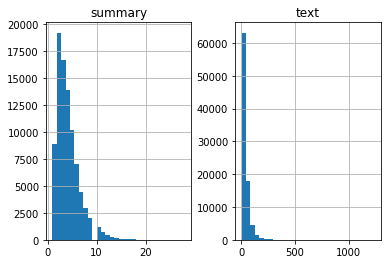

In [15]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [16]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9424907471335922


In [17]:
max_text_len=30
max_summary_len=8

In [18]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [19]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [20]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

In [22]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [23]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.12339930151339
Total Coverage of rare words: 2.953684513790566


In [24]:
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

x_voc   =  x_tokenizer.num_words + 1

In [25]:
x_voc

8440

In [26]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [27]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 78.12740675541863
Total Coverage of rare words: 5.3921899389571895


In [28]:
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

y_voc  =   y_tokenizer.num_words +1

In [29]:
y_tokenizer.word_counts['sostok'],len(y_tr)   

(42453, 42453)

In [30]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [31]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)


In [40]:
X_test, y_test = x_val[:500], y_val[:500]
x_val, y_val = x_val[500:], y_val[500:]

In [32]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

encoder_inputs = Input(shape=(max_text_len,))

enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
                                                                                    
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      844000      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 30, 300), (N 481200      embedding[0][0]                  
________________________________________________________

In [37]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [38]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [39]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 41346 samples, validate on 4588 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
41346/41346 [==============================] - 511s 12ms/sample - loss: 2.8285 - val_loss: 2.5979
Epoch 2/50
41346/41346 [==============================] - 506s 12ms/sample - loss: 2.5143 - val_loss: 2.4610
Epoch 3/50
41346/41346 [==============================] - 504s 12ms/sample - loss: 2.3657 - val_loss: 2.3237
Epoch 4/50
41346/41346 [==============================] - 501s 12ms/sample - loss: 2.2635 - val_loss: 2.2767
Epoch 5/50
41346/41346 [==============================] - 501s 12ms/sample - loss: 2.1936 - val_loss: 2.1994
Epoch 6/50
41346/41346 [==============================] - 499s 12ms/sample - loss: 2.1424 - val_loss: 2.1847
Epoch 7/50
41346/41346 [==============================] - 502s 12ms/sample - loss: 2.0992 - val_loss: 2.1345
Epoch 8/50
41346/41346 [==============================] - 505s 12ms/sample - loss: 2.0628 - va

In [40]:
model.save_weights('model')

In [33]:
model.load_weights('model')

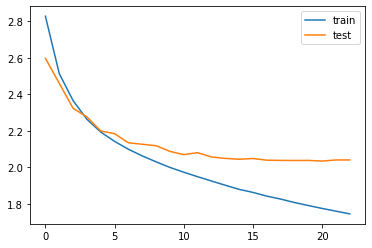

In [41]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [34]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [35]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

dec_emb2= dec_emb_layer(decoder_inputs) 
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_dense(decoder_inf_concat) 

decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [45]:
def decode_sequence(input_seq):

    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    target_seq = np.zeros((1,1))
    
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence

In [44]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [46]:
for i in range(0,500):
    print("Review:",seq2text(X_test[i]))
    print("Original summary:",seq2summary(y_test[i]))
    print("Predicted summary:",decode_sequence(X_test[i].reshape(1,max_text_len)))
    print("\n")

Review: great teas love brewer dispenser big fan mango though others great 
Original summary: teas please 
Predicted summary:  great tea


Review: month old german shepherd loves kind like licorice easy break apart fall apart bad gone less week lol 
Original summary: good 
Predicted summary:  not that great


Review: wonderful old standby great snacking gotta taste cheese much similar 
Original summary: cheez it it is the 
Predicted summary:  delicious


Review: used buy shake bake years ago forgot always like one pork one way get pork chops tender like crispy coating probably buy 
Original summary: quick easy and tasty pork coating 
Predicted summary:  great product


Review: much flavor would use heavier sauce use chicken noodle soup better day chance soak broth little hard recommend cooking little longer package recommends 
Original summary: it is okay but not fabulous 
Predicted summary:  great seasoning


Review: sour apple chips sour eat one chip time well since taste great lets 

Predicted summary:  not as good as other brands


Review: subscribe save getting case month ability order fancy feast line bulk real convenience 
Original summary: great assortment real convenience 
Predicted summary:  great


Review: purchased experiment see effects would nothing happened know due something specific company product whether would effect price worth experimenting nothing happens 
Original summary: no results 
Predicted summary:  not as good as expected


Review: tried many think thin bars chunky peanut butters favorite sweet good consistency go lot helped loose maintain weight taste good 
Original summary: live on these things 
Predicted summary:  great taste


Review: tastes good well velveeta buying broccoli bother tsp dried broccoli included package hardly makes broccoli 
Original summary: really 
Predicted summary:  great taste


Review: longer find local stores whole family loves kids love hear pop taste good prefer popcorn happy find buy 
Original summary: very go

Predicted summary:  great taste


Review: tried lot hemp protein last several years found undrinkable actually enjoy version probably gone two dozen containers blend bananas either almond coconut milk outstanding 
Original summary: the best protein product have found 
Predicted summary:  great taste


Review: discovered last journey london really loved purchased amazon soon saw travel london expensive 
Original summary: is our choice 
Predicted summary:  good stuff


Review: bought daughter party well strawberry loves things great product 
Original summary: great product 
Predicted summary:  great taste


Review: purchased pretzels make chocolate covered wedding favors guests pretzels would bad anything else way many broken ones would buy five complaint shipped back month ago still received refund 
Original summary: pretzels 
Predicted summary:  not as good as other flavors


Review: product purchased wood elk rack needed fake would nt able use arrived within days using first class mai

Predicted summary:  not bad


Review: got expecting night day compared typical kernels hard tell difference awesome price point sure visually pop prepared guests used popped 
Original summary: not popcorn 
Predicted summary:  great popcorn


Review: get brand size bj half price shipping buy bags time good 
Original summary: love mango 
Predicted summary:  great price


Review: lavazza oro smoothest mellow espresso tried gold standard espresso measured 
Original summary: makes great latte 
Predicted summary:  great coffee


Review: really really bad got deal would encourage anyone buy previous reviewer stated terrible chemical taste really disappointed save money buy balance power bar brand mean awful 
Original summary: really really bad 
Predicted summary:  horrible


Review: mints whiff local candy decided get anyway since latte mints tried like one direction 
Original summary: tastes great but smells 
Predicted summary:  good stuff


Review: great still mine wrapped never seem finish

Predicted summary:  great tea


Review: soooo good good better girl scout cookies lets remember though cookies go good cause available buy great cookies year long yumm 
Original summary: awesome 
Predicted summary:  best cookie ever


Review: great ever tried hold cat stuff pill throat might get away first second time tolerate long see coming pet pockets practically knock get treat highly recommend product cat loves chicken 
Original summary: texas 
Predicted summary:  my cat loves it


Review: purchased item amazon local grocery store longer carries love product add home made breads morning oatmeal buying amazon turned less expensive buying grocery store 
Original summary: love the product 
Predicted summary:  great product


Review: keep box saltines nearby stuff best lunch microwave ever years working nice thick weird burnt spices mystery meat buy 
Original summary: good for lunch 
Predicted summary:  great for cooking


Review: dog loved feel guilty giving treat good large dogs hea

Predicted summary:  not as advertised


Review: dogs love peanut butter crackers last one finally came around eats seem little dry think go waste price good shipping time fine 
Original summary: dog treats 
Predicted summary:  dogs love them


Review: tried ginger teas even made scratch still like ginger aid best winter months drink cup every evening steeping minutes tea settle stomach keeps alert extra hour without sleep later 
Original summary: perfect after dinner 
Predicted summary:  great tea


Review: white cheddar kernel seasoning fantastic surprised terrible flavor like tangy barbecue chip taste like sickly sweet good 
Original summary: not good 
Predicted summary:  great taste


Review: love used spaghetti sauce stir fry soft shell etc delicious wish less expensive think would eat everyday 
Original summary: fantastic 
Predicted summary:  great sauce


Review: delicious instant stevia sweetened lemonade fast delivery lemon flavor right overpowering sweetness like instant teas 

Predicted summary:  great tea


Review: love bars one breakfast every morning chocolate peanut butter nuts start morning happy face also cheaper buy amazon grocery store 
Original summary: breakfast bars at amazon 
Predicted summary:  great bars


Review: big red soda texas excellent hard exact taste say bubble gum others compare cherry regardless definitely give try best tasted cold regret wish distributed new england 
Original summary: big red absolutely the best 
Predicted summary:  good stuff


Review: fantastic french dressing unable find grocery stores excited find amazon thought price reasonable 
Original summary: delicious but hard to find 
Predicted summary:  great taste


Review: purchased saturday night received tuesday beans super oily really like roast really good french roast produces full bodied coffee slightly sweeter note im used pounds great everyday coffee 
Original summary: great price good 
Predicted summary:  great coffee


Review: small juice tasty carbonation ma

Predicted summary:  great product


Review: personal preference stay clear like smell taste make pizza crust first time second attempt came better like taste least liked taste would buy make crust thin 
Original summary: not fan 
Predicted summary:  not bad


Review: ordered dec hoping would get go christmas made noon th great service 
Original summary: fast service 
Predicted summary:  great product


Review: first time much gas fart eating cake two hours meal almost guaranteed start suffer lasts entire day wife certain uncomfortable 
Original summary: gas and 
Predicted summary:  great for dogs


Review: product arrived right scheduled time shake great pre post workout absolutely love tastes good milk even water definitely great way help lose weight stay healthy 
Original summary: the best shake out there 
Predicted summary:  great product


Review: dog gets practice critical thinking mind figuring get treat love wheel also serve great entertainment tool see dog figure social 
Origin

Predicted summary:  not as good as was


Review: macadamia nuts expensive product also expensive tastes reasonably good add little splenda top spread pretty good think order cashew butter next time 
Original summary: pricey but good 
Predicted summary:  great taste


Review: hard get timing right plus funny smell buying anymore 
Original summary: so so 
Predicted summary:  not good


Review: special bars great husband loves healthier junk food used eat 
Original summary: special bar blueberry 
Predicted summary:  great bars


Review: love product use smoothie every day wonderful product sometimes look forward getting terrific raw dishes raw organic cacao great source 
Original summary: great cacao 
Predicted summary:  great product


Review: walmart south carolina picked traveling helped 
Original summary: awesome 
Predicted summary:  great product


Review: much salt similiar wheat thins think would prefer wheat thins salt burns tongue barely eat crackers one sitting 
Original summary

Predicted summary:  great coffee


Review: easy go typically make food little one makes easy running errands baby loves 
Original summary: great product good food 
Predicted summary:  great food


Review: recently found allergic wheat gluten milk love baking excited found pamela chocolate chip cookie mix friends even notice difference wonderful mix good easy highly recommend mix 
Original summary: this cookie mix is amazing 
Predicted summary:  great gluten free snack


Review: jerky used wonder cannot find local stores horrible chemical taste unfortunately case bought garbage waste money stuff inedible 
Original summary: do not buy it 
Predicted summary:  not


Review: kimchi noodle ordered amazon worst ever used buy korean grocery kimchi noodle got grocery small bag kimchi included product amazon kimchi hate product 
Original summary: my noodle experience 
Predicted summary:  not bad


Review: love stuff hot touch honey milk chilled ice touch honey lovely flavor say least fan happy f

Predicted summary:  not as good as starbucks


Review: pleasantly surprised foods sprouted pumpkin seeds party mix nice spicey bite crunchy really delish garlic sea salt sunflower seeds good 
Original summary: party mix is delish 
Predicted summary:  great seeds


Review: great product grows pretty quickly kitty fond im sure would rather eat grass outside 
Original summary: good product but not tasty enough 
Predicted summary:  good food


Review: wonderful kit ferment quickly use excellent ingredients added benefit labels foil seals best part taste good medium body quite good 
Original summary: excellent 
Predicted summary:  great product


Review: coffee like smooth light roast coffee care light roast coffee 
Original summary: coffee on the side 
Predicted summary:  great coffee


Review: nothing product bother link top page buy used chewing gum lose flavor overnight alaska 
Original summary: have this gum many times but used 
Predicted summary:  not what expected


Review: really en

Predicted summary:  love these chips


Review: excellent candy us limit chocolate intake bar six pieces helps portion control makes perfect sharing sometimes hard get paper candy quite sticky 
Original summary: yummy 
Predicted summary:  delicious


Review: month old loves packs best long car trips want stop pull meal worth food little one happily suck drive 
Original summary: baby approved 
Predicted summary:  my daughter loves these


Review: enjoyed nuts found handful appetite looking snack cocoa flavor nice overly sweet able satisfy craving chocolate 
Original summary: snack with just light touch of cocoa 
Predicted summary:  great snack


Review: cereal tastes great get soggy something family really appreciates like honey nut love kellogg crunchy nut cereal 
Original summary: great cereal 
Predicted summary:  great cereal


Review: love variety chex mix unfortunately cannot find grocery stores anymore excited find amazon caramel bits especially yummy fell love decided diet weight 

In [42]:
print(model.evaluate([X_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:], batch_size=128))

500/500 [==============================] - 3s 7ms/sample - loss: 1.9879
1.9879455795288086
